1. **Why train model with 2 features at a time" can work?**

Ans:
If all variables were independent. There was nothing to learn on their interactions, so it made sense to train all of the variables as independent models.

However, for each variable, knowing the unique values was important to help the model to predict the result.

So for each one of those models I created another feature about the unique values.

Summary:
Each model had 2 features
1) The original one
2) And another about unique values of that feature.

The lgb model can't recognize on its own properties like unique values. It analyses frequency, which are related to bins, which means that the bin size is about all the values from a certain V1 to V2.

So LGB checks, for example, all the numbers between 1 and 1.2. But It can't say if the number 1.1125687 is unique of not.

It was an odd thing that unique values mattered. Probably it is a by-product of how the data was created.

2. **If I meet another competition whose all feature variables are independent, I can deal them like this way? What I means is, whether it is a usual method to train such features ?**

Ans:
As far as I know, it is very very very very unlikely that you will find real data with over 200 independent variables. Usually, the variables correlate somehow, for exemple: gender and height

If you train variables independently and they are somehow correlated, you will lose information.

But, answering your question: yes, if you find another competition like this, it should work.

## Feature Engineering
1. Multiplication and division between raw feature and its corresponding value count. E.g., `df['var_0'] / df['var_0_count']` and `df['var_0']*df['var_0_count']`, which disperse the distribution of different values with the same counts.
2. Features grouped by `count==1/!1` We created features like rank ratio `(x.rank()/x.rank().max())` and z-score `((x-x.mean())/x.std())` for values whose count equals 1 or greater than 1, respectively. It turns out that `count==1` is very special. Simulated data (generated by some distribution and then rounded to 4 decimals) should have very low PDF towards the mode of the overall distribution of the variable. However, this is not the case for many variables (will upload figures later). The z-score kind of normalizes the distribution so that we can compare the edges of distributions for `count==1/!1` altogether.

In [3]:
import gc
import os
import logging
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
from numba import jit
from datetime import datetime
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings('ignore')

IS_LOCAL = False
if(IS_LOCAL):
    PATH = Path('/mnt/disks/data/santander-customer-transaction/')
else:
    PATH = Path('../input/santander-customer-transaction-prediction')
    
os.listdir(str(PATH))

['test.csv', 'train.csv', 'sample_submission.csv.zip']

In [4]:
%%time
train_df = pd.read_csv(str(PATH / 'train.csv'))
test_df = pd.read_csv(str(PATH / 'test.csv'))

CPU times: user 17.7 s, sys: 916 ms, total: 18.6 s
Wall time: 18.6 s


In [5]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

In [6]:
target_col = 'target'
predictor_cols = [c for c in train_df.columns if c not in ['ID_code', 'target']]
# predictor_cols = [x for x in train_df.columns if x.startswith('var')]

# Reverse features

In [ ]:
# 只是將相關性從負向轉為正向，但值並不會改變，分布也不會改變
for var in predictor_cols:
    if np.corrcoef(train_df['target'], train_df[var])[1][0] < 0:
        train_df[var] = train_df[var] * -1
        test_df[var] = test_df[var] * -1
    

In [117]:
# Count all values
var_stats = {}
hist_df = pd.DataFrame()
for var in predictor_cols:
    var_stats = train_df[var].append(test_df[var]).value_counts()
    hist_df[var] = pd.Series(test_df[var]).map(var_stats)
    hist_df[var] = hist_df[var] > 1

# remove fake test rows
ind = hist_df.sum(axis=1) != 200    

In [123]:
# recount values without fake rows
var_stats = {}
for var in predictor_cols:
    var_stats[var] = train_df[var].append(test_df[ind][var]).value_counts()


In [125]:
def logit(p):
    return np.log(p) - np.log(1 - p)

def var_to_feat(vr, var_stats, feat_id):
    new_df = pd.DataFrame()
    new_df['var'] = vr.values
    new_df['hist'] = pd.Series(vr).map(var_stats)
    new_df['feature_id'] = feat_id
    new_df['var_rank'] = new_df['var'].rank() / 200000
    return new_df.values

In [126]:
TARGET = np.array( list(train_df['target'].values) * 200 )

In [131]:
TRAIN = []
var_mean = {}
var_var  = {}
for var in predictor_cols:
    tmp = var_to_feat(train_df[var], var_stats[var], int(var[4:]) )
    var_mean[var] = np.mean(tmp[:,0]) 
    var_var[var]  = np.var(tmp[:,0])
    tmp[:,0] = (tmp[:,0]-var_mean[var])/var_var[var]
    TRAIN.append( tmp )
TRAIN = np.vstack( TRAIN )

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

# List of fake samples and public / private LB split

The statistics of training set and test set are very similar.

However, one thing that caught my eye was the fact that the distribution of the number of unique values (across features) is significantly different between training set and test set.

It seems that the test set consists of real samples as well as synthetic samples that were generated by sampling the real samples feature distributions (These are probably the "rows which are not included in scoring").

If this is correct, then finding out which sample is synthetic, and which is real should be relatively easy task:

Given a sample, we can go over its features and check if the feature value is unique. If at least one of the sample's features is unique, then the sample must be a real sample. It turns out that if a given sample has no unique values then it is a synthetic sample. (It doesn't have to be like that, but in this dataset the probability is seemingly to low that this would not be the case).

In [35]:
# === unique value ===
data = pd.concat([train_df, test_df], axis=0, sort=False)
col_var = train_df.columns[2:]
df = pd.DataFrame(col_var, columns=['feature'])
df['n_train_unique'] = train_df[col_var].nunique(axis=0).values
df['n_test_unique'] = test_df[col_var].nunique(axis=0).values

for i in df.index:
    col = df.loc[i, 'feature']
    df.loc[i, 'n_overlap'] = int(np.isin(train_df[col].unique(), test_df[col]).sum())

df['value_range'] = data[col_var].max(axis=0).values - data[col_var].min(axis=0).values

In [37]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
feature,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
n_train_unique,94672,108932,86555,74597,63515,141029,38599,103063,98617,49417,...,114959,94266,59065,110557,97069,57870,125560,40537,94153,149430
n_test_unique,65580,71661,61865,56507,49995,83228,33273,69487,67521,41583,...,73782,65460,47041,72171,66942,46482,78038,34817,65262,85933
n_overlap,50355,50587,49650,48421,44629,42010,30990,51766,51791,38639,...,49140,50567,41723,50039,51733,41500,48052,32305,50239,38046
value_range,22.1347,25.4202,17.2359,13.2285,11.5966,49.8163,6.2313,22.9431,20.6568,7.1801,...,34.4523,19.4082,12.2169,30.0652,19.2534,9.8064,32.5311,6.3152,20.2391,67.9585


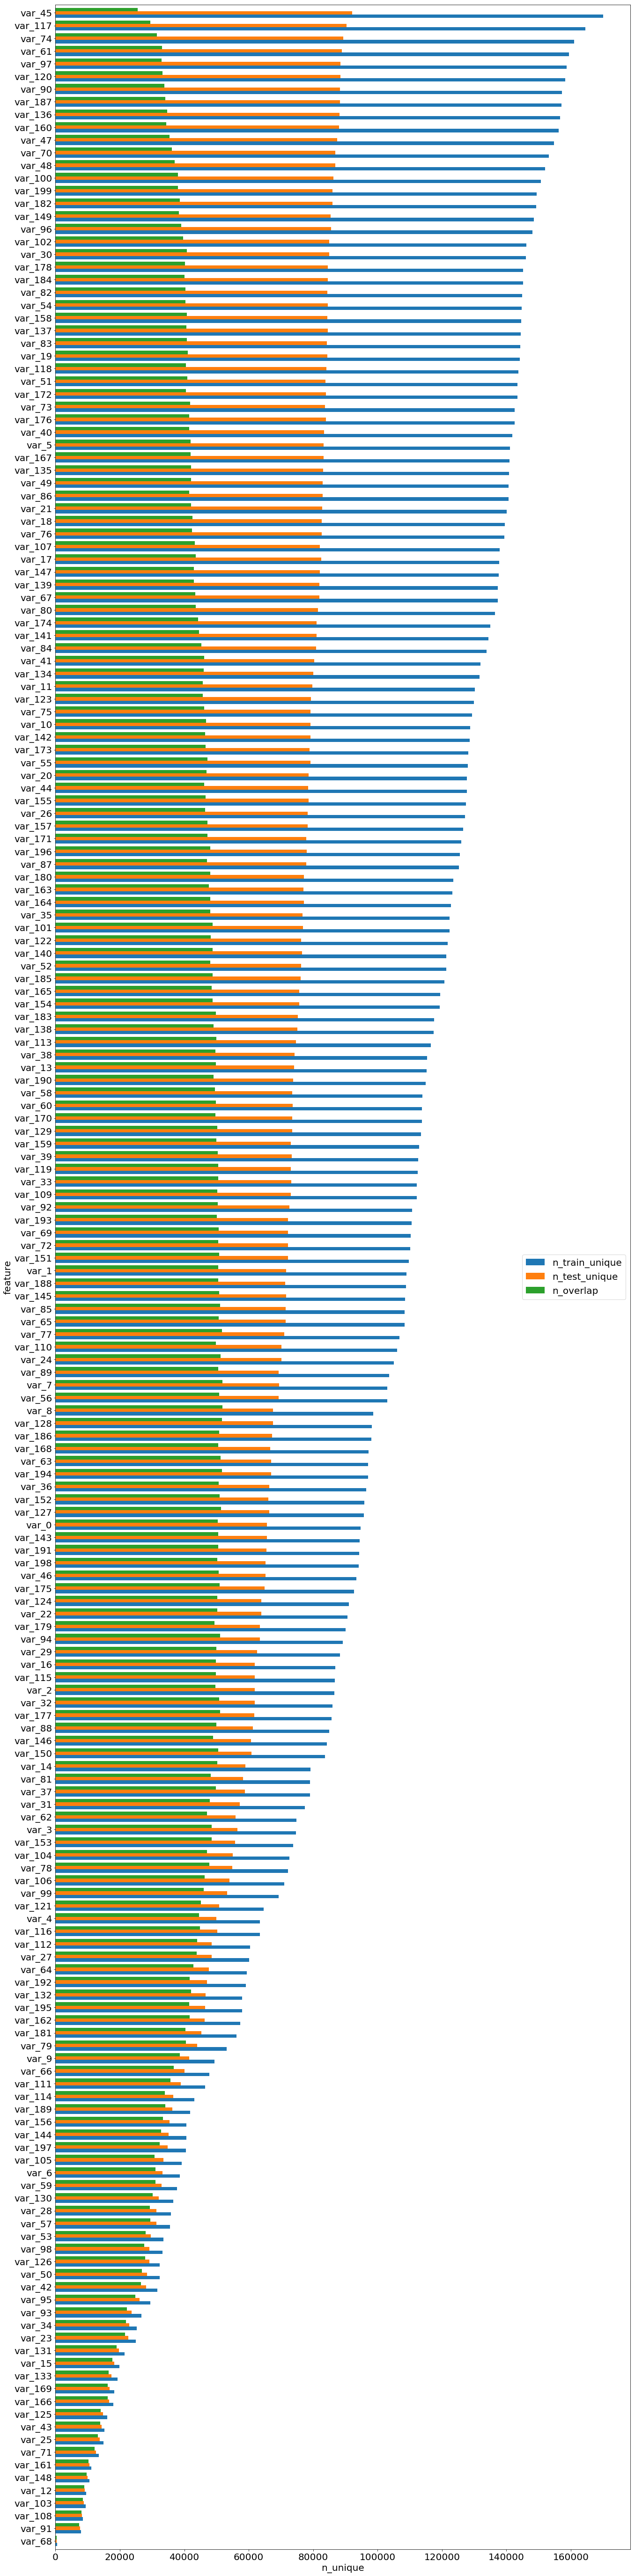

In [38]:
# === plot ===
df = df.sort_values(by='n_train_unique').reset_index(drop=True)
df[['n_train_unique', 'n_test_unique', 'n_overlap']].plot(kind='barh' ,figsize=(22, 100), fontsize=20, width=0.8)
plt.yticks(df.index, df['feature'].values)
plt.xlabel('n_unique', fontsize=20)
plt.ylabel('feature', fontsize=20)
plt.legend(loc='center right', fontsize=20)

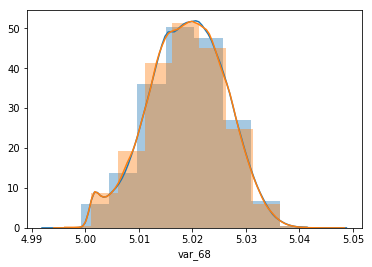

In [52]:
feature = 'var_68'
bins = 10
sns.distplot(train_df[feature], label='train', kde=True, rug=False, hist=True, bins=bins) 
sns.distplot(test_df[feature], label='test', kde=True, rug=False, hist=True, bins=bins)
       

In [58]:
df_test = test_df[predictor_cols].values
unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in tqdm(range(df_test.shape[1])):
    # 計算每一個 feature 的 unique count value
    _, index, count = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    # 取出 value count == 1 的 value 所對應的 index
    unique_count[index[count == 1],  feature] += 1

100%|██████████| 200/200 [00:05<00:00, 33.25it/s]


In [ ]:
value, index, count = np.unique(df_test[:, feature], return_counts=True, return_index=True)

In [114]:
test_df[test_df.var_199 == value[0]]

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
7097,test_7097,9.5582,4.7533,9.4395,9.4766,9.5197,-0.1332,4.3668,17.2772,0.8433,...,9.9739,5.2669,3.0296,6.7101,20.9042,1.3552,7.1170,8.7045,14.1495,-39.4578
82765,test_82765,8.5727,-7.4996,12.6308,7.4621,14.0429,7.5208,4.7576,21.0484,5.7642,...,6.9621,7.8111,1.6861,8.3227,20.0151,-2.9146,6.2771,7.0894,11.7817,-39.4578
165682,test_165682,11.7996,0.2698,11.7284,6.1293,9.6822,2.8101,5.0787,17.9483,0.7820,...,2.7237,7.0378,1.5043,-1.1829,19.8702,0.4165,9.3736,8.8669,18.1988,-39.4578


In [105]:
value[count == 1]

array([-36.3251, -35.7908, -35.158 , ...,  24.741 ,  24.7922,  25.7845])

In [106]:
test_df[test_df.var_199 == -36.3251]

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
135371,test_135371,6.0005,-2.3324,11.7671,10.6508,8.5606,1.72,5.5881,17.2391,6.0901,...,-1.6093,6.9223,1.1932,0.4539,20.5233,1.9403,5.5184,8.6058,10.0457,-36.3251


In [12]:
# 依據每一筆 row 計算加總所對應的 feature 有哪幾個 feature 的 value 是 count == 1 
# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print(len(real_samples_indexes)) # real sample index
print(len(synthetic_samples_indexes)) # synthetic sample index

100000
100000


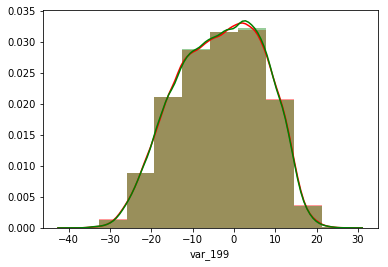

In [130]:
feature = 'var_199'
sns.distplot(test_df[feature][real_samples_indexes], label='train', kde=True, rug=False, hist=True, bins=bins, color='r') 
sns.distplot(test_df[feature][synthetic_samples_indexes], label='test', kde=True, rug=False, hist=True, bins=bins, color='g')
       

In [83]:
np.argwhere(np.sum(unique_count, axis=1) > 0)

array([[     3],
       [     7],
       [    11],
       ...,
       [199995],
       [199996],
       [199999]])

If the split between private and public LB sets was done before the resampling process of generating synthetic samples, then it's also possible to regenerate the two different sets. For each synthetic sample, we can go over its features and capture those features that have only one instance in the real samples set with the same value, this instance has to be one of the samples' generators.

In [ ]:
real_test_df = df_test[real_samples_indexes].copy()
generator_for_each_synthetic_sample = []

for cur_sample_index in tqdm(synthetic_samples_indexes[:20000]):
    cur_synthetic_sample = df_test[cur_sample_index]
    potential_generators = real_test_df == cur_synthetic_sample
    
    # A verified generator for a synthetic sample is achieved
    # only if the value of a feature appears only once in the
    # entire real samples set
    features_mask = np.sum(potential_generators, axis=0) == 1
    verified_generators_mask = np.any(potential_generators[:, features_mask], axis=1)
    verified_generators_for_sample = real_samples_indexes[np.argwhere(verified_generators_mask)[:, 0]]
    generator_for_each_synthetic_sample.append(set(verified_generators_for_sample))


In [159]:
len(generator_for_each_synthetic_sample)

20000

In [160]:
# After collecting the "verified generators" for each fake sample, 
# finding the Public/Private LB split is no more than a few set operations.
public_LB = generator_for_each_synthetic_sample[0]
for x in tqdm(generator_for_each_synthetic_sample):
    if public_LB.intersection(x):
        public_LB = public_LB.union(x)

private_LB = generator_for_each_synthetic_sample[1]
for x in tqdm(generator_for_each_synthetic_sample):
    if private_LB.intersection(x):
        private_LB = private_LB.union(x)
        
print(len(public_LB))
print(len(private_LB))

100%|██████████| 20000/20000 [00:14<00:00, 1356.89it/s]

50000
50000


In [161]:
np.save('public_LB', list(public_LB))
np.save('private_LB', list(private_LB))
np.save('synthetic_samples_indexes', list(synthetic_samples_indexes))

# Unique count

In [14]:
full_df = pd.concat([train_df, test_df], axis=0)

In [25]:
for f in tqdm(predictor_cols):
    unique_count_dict = full_df[f].value_counts().to_dict()
    train_df['un_real_' + f] = train_df[f].apply(lambda x: x if unique_count_dict[x] == 1 else np.nan).values
    test_df['un_real_' + f] = test_df[f].apply(lambda x: x if unique_count_dict[x] == 1 else np.nan).values
    

100%|██████████| 200/200 [00:58<00:00,  2.02it/s]


In [ ]:
df = pd.concat([train,real_test], axis = 0)
for feat in tqdm_notebook(features):
    df[feat+'_var'] = df.groupby([feat])[feat].transform('var')
for feat in tqdm_notebook(features):
    df[feat+'plus_'] = df[feat] + df[feat+'_var']
    df[feat+'minus_'] = df[feat] - df[feat+'_var']

## Convert var_68 to datetime

In [4]:
epoch_datetime = pd.datetime(1900, 1, 1)
trf_var_68_s = (train_df['var_68']*10000 - 7000 + epoch_datetime.toordinal()).astype(int)
date_s = trf_var_68_s.map(datetime.fromordinal)
train_df['date'] = date_s
sorted_train_df = train_df.drop('var_68', axis=1).sort_values('date')

In [5]:
sorted_train_df.reset_index(inplace=True)
sorted_train_df.drop('index', axis=1, inplace=True)

## Try to use stacking method

In [34]:
train_part_1_df = train_df.sample(train_df.shape[0] // 2, replace=False)
train_part_2_df = train_df.iloc[~train_part_1_df.index.values, :]

In [35]:
train_part_1_df.shape, train_part_2_df.shape

((100000, 202), (100000, 202))

# Features engineering

### Features Interaction

In [36]:
%%time
for df in [test_df, train_df]:
    df['sum'] = df[features].sum(axis=1)  
    df['min'] = df[features].min(axis=1)
    df['max'] = df[features].max(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['std'] = df[features].std(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurtosis(axis=1)
    df['med'] = df[features].median(axis=1)

CPU times: user 14.5 s, sys: 12.3 s, total: 26.8 s
Wall time: 26.8 s


In [5]:
full_df = pd.concat([train_df.drop(['target', 'sum', 'min', 'max', 'mean', 'std', 'skew', 'kurt', 'med'], axis=1),
                     test_df.drop(['sum', 'min', 'max', 'mean', 'std', 'skew', 'kurt', 'med'], axis=1)], 
                    axis=0).copy()
full_df.reset_index(inplace=True)
full_df.drop(['index'], axis=1, inplace=True)

### features slice windows

In [49]:
drop_cols = ['var_68']
train_df.drop(drop_cols, inplace=True, axis=1)
test_df.drop(drop_cols, inplace=True, axis=1)

In [50]:
predictor_cols.remove(*drop_cols)

In [ ]:
%%time
slice_size = [3, 7]
stride = 2

for s in slice_size:
    total_slice = (len(predictor_cols)-s) // stride + 1
    for i in tqdm(range(total_slice)):
        new_feature = predictor_cols[(i*stride):((i*stride + s))]
        # train
        train_df['ws_mean_{}_{}'.format(s, i)] = train_df[new_feature].mean(axis=1)
        train_df['ws_std_{}_{}'.format(s, i)] = train_df[new_feature].std(axis=1)
        train_df['ws_min_{}_{}'.format(s, i)] = train_df[new_feature].min(axis=1)
        train_df['ws_max_{}_{}'.format(s, i)] = train_df[new_feature].max(axis=1)
        # test
        test_df['ws_mean_{}_{}'.format(s, i)] = test_df[new_feature].mean(axis=1)
        test_df['ws_std_{}_{}'.format(s, i)] = test_df[new_feature].std(axis=1)
        test_df['ws_min_{}_{}'.format(s, i)] = test_df[new_feature].min(axis=1)
        test_df['ws_max_{}_{}'.format(s, i)] = test_df[new_feature].max(axis=1)
  

## Feature Transformation

### Convert numeric features to categories features

In [6]:
from sklearn.preprocessing import Binarizer
unique_value_df = train_df.drop(['ID_code', 'target', 'sum', 'min', 'max', 'mean', 'std', 'skew', 'kurt', 'med'], 
                                axis=1).nunique().sort_values()
convert_to_categories_cols = unique_value_df[unique_value_df > 100000].index.values

In [8]:
%%time
from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
label_encoder = LabelEncoder()

for c in list(convert_to_categories_cols):
    cate_range = np.arange(full_df[c].min(), full_df[c].max(), 
                          (full_df[c].max() - full_df[c].min()) / 10).tolist() + [full_df[c].max()]
    res = pd.cut(full_df[c], cate_range, include_lowest=True,
                 labels=list(map(lambda i:str(i), range(1, len(cate_range)))))
    
    one_hot_encoder = OneHotEncoder(sparse=False).fit(np.array(res).reshape(-1, 1))
    one_hot_res = one_hot_encoder.transform(np.array(res).reshape(-1, 1))
    
    cols = [c + '_' + str(i) for i in range(1, len(cate_range))]
    res_df = pd.DataFrame(one_hot_res, columns=cols).drop(cols[-1], axis=1)
    full_df = pd.concat([full_df, res_df], axis=1).drop(c, axis=1)


NameError: name 'convert_to_categories_cols' is not defined

In [8]:
remain_cols = [i for i in predictor_cols if i not in convert_to_categories_cols]
full_df.drop(remain_cols[2:], axis=1, inplace=True)

train_df = train_df.merge(full_df, on='ID_code', how='left')
test_df = test_df.merge(full_df, on='ID_code', how='left')

In [9]:
predictor_cols = train_df.columns.drop(['ID_code', 'target'])

In [10]:
del full_df
gc.collect()

252

### Use the data of target 1 to cut data and convert to categoris features

In [6]:
target_1_df = train_df.loc[train_df['target'] == 1]

In [133]:
convert_predictor_cols = ['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_8', 'var_9', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15',
       'var_16', 'var_18', 'var_19', 'var_20', 'var_21', 'var_22',
       'var_23', 'var_24', 'var_25', 'var_26', 'var_28', 'var_31',
       'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37',
       'var_40', 'var_42', 'var_43', 'var_44', 'var_45', 'var_47',
       'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53',
       'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59',
       'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65',
       'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71',
       'var_72', 'var_73', 'var_74', 'var_75', 'var_76', 'var_77',
       'var_78', 'var_79', 'var_80', 'var_81', 'var_82', 'var_83',
       'var_84', 'var_85', 'var_86', 'var_87', 'var_88', 'var_89',
       'var_90', 'var_91', 'var_92', 'var_93', 'var_94', 'var_95',
       'var_97', 'var_99', 'var_101', 'var_102', 'var_104', 'var_105',
       'var_106', 'var_107', 'var_108', 'var_109', 'var_110', 'var_111',
       'var_112', 'var_113', 'var_114', 'var_115', 'var_116', 'var_118',
       'var_119', 'var_120', 'var_121', 'var_122', 'var_123', 'var_125',
       'var_127', 'var_128', 'var_129', 'var_130', 'var_131', 'var_132',
       'var_133', 'var_134', 'var_135', 'var_137', 'var_138', 'var_139',
       'var_140', 'var_141', 'var_142', 'var_143', 'var_144', 'var_145',
       'var_146', 'var_147', 'var_148', 'var_149', 'var_150', 'var_151',
       'var_152', 'var_153', 'var_154', 'var_155', 'var_156', 'var_157',
       'var_159', 'var_162', 'var_163', 'var_164', 'var_165', 'var_166',
       'var_167', 'var_168', 'var_169', 'var_170', 'var_171', 'var_172',
       'var_173', 'var_174', 'var_175', 'var_176', 'var_177', 'var_178',
       'var_179', 'var_180', 'var_181', 'var_182', 'var_184', 'var_186',
       'var_187', 'var_188', 'var_189', 'var_190', 'var_191', 'var_192',
       'var_193', 'var_194', 'var_195', 'var_196', 'var_197', 'var_198',
       'var_199']

In [83]:
convert_df = pd.DataFrame()
for f in convert_predictor_cols:
    cate_range = target_1_df[f].quantile([0.25, 0.5, 0.75]).values.tolist()
    cate_range.insert(0, train_df[f].min() - 0.001)
    cate_range.append(train_df[f].max() + 0.001)
    res = pd.cut(train_df[f], cate_range, include_lowest=True,
                 labels=list(map(lambda i:str(i), range(1, len(cate_range)))))
    res = res.astype(int)
    #one_hot_encoder = OneHotEncoder(sparse=False).fit(np.array(res).reshape(-1, 1))
    #one_hot_res = one_hot_encoder.transform(np.array(res).reshape(-1, 1))
    
    #cols = [c + '_' + str(i) for i in range(1, len(cate_range))]
    cols = [f + '_' + 'bin']
    #res_df = pd.DataFrame(res, columns=cols)
    convert_df = pd.concat([convert_df, res], axis=1)

convert_df.columns = [f + '_' + 'bin' for f in convert_predictor_cols]

In [76]:
Counter(res.isna())

Counter({False: 200000})

In [89]:
train_df = pd.concat([train_df, convert_df], axis=1)

In [111]:
convert_test_df = pd.DataFrame()
for f in convert_predictor_cols:
    cate_range = target_1_df[f].quantile([0.25, 0.5, 0.75]).values.tolist()
    cate_range.insert(0, test_df[f].min() - 0.001)
    cate_range.append(test_df[f].max() + 0.001)
    res = pd.cut(test_df[f], cate_range, include_lowest=True,
                 labels=list(map(lambda i:str(i), range(1, len(cate_range)))))
    res = res.astype(int)
    #one_hot_encoder = OneHotEncoder(sparse=False).fit(np.array(res).reshape(-1, 1))
    #one_hot_res = one_hot_encoder.transform(np.array(res).reshape(-1, 1))
    
    #cols = [c + '_' + str(i) for i in range(1, len(cate_range))]
    cols = [f + '_' + 'bin']
    #res_df = pd.DataFrame(res, columns=cols)
    convert_test_df = pd.concat([convert_test_df, res], axis=1)

convert_test_df.columns = [f + '_' + 'bin' for f in convert_predictor_cols]

In [112]:
test_df = pd.concat([test_df, convert_test_df], axis=1)


# Split data

In [21]:
'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
split_probability = 0.25
seed = 8787
train_data, valid_data = train_test_split(train_df,
                                          test_size=split_probability, 
                                          stratify=train_df['target'],
                                          shuffle=True,
                                          random_state=seed)

print("train size: ", train_data.shape[0])
print("valid size: ", valid_data.shape[0])
'''

train size:  150000
valid size:  50000


# Model

In [27]:
import multiprocessing
import itertools
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold, KFold
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import warnings

warnings.filterwarnings('ignore')

## XGBoost

In [83]:
num_of_iter = 1000000
num_early_stopping = 4000
num_verbose_eval = 5000

In [90]:
sk_params = {
    'learning_rate': 0.01,
    'n_estimators': num_of_iter,                                   
    'objective': 'binary:logistic', 
    'n_jobs': multiprocessing.cpu_count(),
    'tree_method': "gpu_hist",  # auto, hist, gpu_hist
    'n_gpus': -1,
    'eval_metric': ['auc'], # 'logloss'
    'random_state':  seed,
    'verbosity': 2,
    #'gamma': 0, # Minimum loss reduction required to make a further partition on a leaf node of the tree, alias min_split_loss. It acts as a regularization parameter. Either 0, 1 or 5.
    'max_depth': 5, # 0 means no limit (useful only for depth wise grow policy).
    'min_child_weight': 10.0, # Minimum sum of instance weight (hessian) needed in a child.
    'subsample': 0.335, # Subsample ratio of the training instances.
    'colsample_bytree': 0.04, # subsample ratio of columns when constructing each tree.
    #'colsample_bylevel': 1, # subsample ratio of columns for each level.
    'reg_lambda': 3, # L2 regularization. Increasing this value will make model more conservative.
    #'reg_alpha': 3, # L1 regularization. Increasing this value will make model more conservative.
    #'scale_pos_weight': 1, # Control the balance of positive and negative weights, useful for unbalanced classes.
    #'grow_policy': "lossguide", # split at nodes with highest loss change.
    'max_leaves': 13, # Maximum number of nodes to be added. (for lossguide grow policy).
    'max_bin': 100, # Increasing this number improves the optimality of splits at the cost of higher computation time.
}

In [7]:
%%time
xgb_clf_draft = xgb.XGBClassifier(**sk_params)
eval_set = [(train_data[predictor_cols], train_data[target_col]), 
            (valid_data[predictor_cols], valid_data[target_col])]

xgb_clf_draft.fit(X=train_data[predictor_cols],
                  y=train_data[target_col], 
                  eval_set=eval_set,             
                  early_stopping_rounds=num_early_stopping, 
                  verbose=num_verbose_eval)


[0]	validation_0-auc:0.563491	validation_1-auc:0.557731
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 4000 rounds.
[5000]	validation_0-auc:0.925126	validation_1-auc:0.896326
[10000]	validation_0-auc:0.941072	validation_1-auc:0.900325
[15000]	validation_0-auc:0.952876	validation_1-auc:0.900694
Stopping. Best iteration:
[13356]	validation_0-auc:0.949146	validation_1-auc:0.900843

CPU times: user 1h 41min 10s, sys: 4min 38s, total: 1h 45min 49s
Wall time: 20min 50s


In [87]:
num_folds = 11
folds = StratifiedKFold(n_splits=num_folds, shuffle=False, random_state=2319)
oof = np.zeros(train_part_1_df.shape[0])
oof_2 = np.zeros(train_part_2_df.shape[0])
y_predictions = np.zeros(test_df.shape[0])

In [86]:
predictor_cols = features = [c for c in train_part_1_df.columns if c not in ['ID_code', 'target', 'date']]

In [ ]:
for fold_, (train_idx, val_idx) in enumerate(folds.split(train_part_1_df[predictor_cols].values,
                                                         train_part_1_df[target_col].values)):
    print("===== Fold {} =====".format(fold_))
    
    train_X, train_y = train_part_1_df.iloc[train_idx][predictor_cols], train_part_1_df.iloc[train_idx][target_col] 
    valid_X, valid_y = train_part_1_df.iloc[val_idx][predictor_cols], train_part_1_df.iloc[val_idx][target_col]
    eval_set = [(train_X, train_y), (valid_X, valid_y)]
    cv_model = xgb.XGBClassifier(**sk_params)
    cv_model.fit(X=train_X,
                 y=train_y, 
                 eval_set=eval_set,             
                 early_stopping_rounds=num_early_stopping, 
                 verbose=num_verbose_eval) 
    
    oof[val_idx] = cv_model.predict_proba(train_part_1_df.iloc[val_idx][predictor_cols], 
                                          ntree_limit=cv_model.best_iteration)[:, 1]
    oof_2[val_idx] = cv_model.predict_proba(train_part_1_df.iloc[val_idx][predictor_cols], 
                                          ntree_limit=cv_model.best_iteration)[:, 1]
    y_predictions +=  cv_model.predict_proba(test_df[predictor_cols], 
                                             ntree_limit=cv_model.best_iteration)[:, 1] / folds.n_splits
    
print("CV score: {:<8.10f}".format(roc_auc_score(train_part_1_df[target_col], oof)))   


===== Fold 0 =====
[0]	validation_0-auc:0.524262	validation_1-auc:0.528282
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 4000 rounds.
[5000]	validation_0-auc:0.93808	validation_1-auc:0.896612
[10000]	validation_0-auc:0.95696	validation_1-auc:0.898474
Stopping. Best iteration:
[7702]	validation_0-auc:0.948948	validation_1-auc:0.898711

===== Fold 1 =====
[0]	validation_0-auc:0.52261	validation_1-auc:0.529029
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 4000 rounds.
[5000]	validation_0-auc:0.937875	validation_1-auc:0.897868
[10000]	validation_0-auc:0.957005	validation_1-auc:0.898187
Stopping. Best iteration:
[7992]	validation_0-auc:0.950111	validation_1-auc:0.898544



Text(0.5, 1.0, 'Loss')

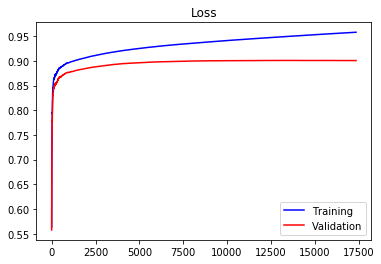

In [8]:
loss = xgb_clf_draft.evals_result()
train_loss = loss['validation_0']['auc']
valid_loss = loss['validation_1']['auc']
iteration = range(len(train_loss))
plt.plot(iteration, train_loss, 'b-', 
         iteration, valid_loss, 'r-')
plt.legend(['Training', 'Validation'])
plt.title('Loss')


In [ ]:
pred_clf = xgb_clf_draft.predict(valid_data[predictor_cols], 
                                 ntree_limit=xgb_clf_draft.best_iteration)[:, 1]

#y_pred = np.argmax(pred_clf >= 0.5, 1)
y_true = valid_data[target].values.tolist()
print('Default setting accuracy: {:.4f}%'.format(accuracy_score(y_true, pred_clf) * 100))


In [81]:
y_true = valid_data[target].values.tolist()
thresholds = np.sort(xgb_clf_draft.feature_importances_)
target_thresholds = list(map(lambda x:thresholds[x], range(0, thresholds.shape[0]//2, 10)))

for thresh in target_thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb_clf_draft, threshold=thresh, prefit=True)
    select_train_data = selection.transform(train_data[predictors])
    select_valid_data = selection.transform(valid_data[predictors])
    
    # train model
    eval_set = [(select_train_data, train_data[target]), (select_valid_data, valid_data[target])]
    selection_model = xgb.XGBClassifier(**sk_params)
    selection_model.fit(X=select_train_data,
                        y=train_data[target], 
                        eval_set=eval_set,  
                        early_stopping_rounds=num_early_stopping, 
                        verbose=False)
    # eval model
    select_valid_data = selection.transform(valid_data[predictors])
    y_pred = selection_model.predict(select_valid_data, ntree_limit=selection_model.best_iteration)
    accuracy = accuracy_score(y_true, y_pred)
    print("Thresh=%.5f, n=%d, Accuracy: %.2f%%" % (thresh, select_train_data.shape[1], accuracy*100.0))

Thresh=0.00239, n=200, Accuracy: 92.08%
Thresh=0.00265, n=190, Accuracy: 92.17%
Thresh=0.00272, n=180, Accuracy: 92.15%
Thresh=0.00282, n=170, Accuracy: 92.19%
Thresh=0.00296, n=160, Accuracy: 92.19%
Thresh=0.00308, n=150, Accuracy: 92.19%
Thresh=0.00318, n=140, Accuracy: 92.05%
Thresh=0.00346, n=130, Accuracy: 92.16%
Thresh=0.00358, n=120, Accuracy: 92.18%
Thresh=0.00389, n=110, Accuracy: 91.96%


In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_importance(xgb_clf, importance_type='gain', max_num_features=30, height=0.5, ax=ax)

# LightGBM

In [28]:
num_of_iter = 1000000
num_early_stopping = 4000
num_verbose_eval = 5000
seed = 2319

In [7]:
labels_weight = train_df['target'].value_counts()[0] / train_df['target'].value_counts()[1]

sk_params = {
    'boosting_type': 'gbdt', # goss, dart
    'subsample_freq': 5,
    'num_leaves': 13,
    'max_depth': -1,
    'learning_rate': 0.0083,
    'n_estimators': num_of_iter,
    #'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'objective': 'binary',
    'metrics': ['auc'],
    #'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'min_child_weight': 10.0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'min_child_samples': 80,  # Minimum number of data need in a child(min_data_in_leaf)
    'subsample': 0.335,
    'colsample_bytree': 0.041,
    #'reg_alpha': 3,  # L1 regularization term on weights
    #'reg_lambda': 3,
    'random_state': seed,
    'n_jobs': multiprocessing.cpu_count(),
    #'scale_pos_weight': labels_weight,
    #'max_bin': 255,
    'boost_from_average':'false',
    'tree_learner': 'serial'
}


In [30]:
predictor_cols = [c for c in train_df.columns if c not in ['ID_code', 'target']]

#categorical_cols = [f + '_' + 'bin' for f in convert_predictor_cols]

In [48]:
predictor_cols = ['var_2', 'var_6', 'var_191', 'new_var']
feature_1 = 'var_2'
feature_2 = 'var_6'
feature_3 = 'var_191'

In [49]:
train_df['new_var'] = np.sqrt(train_df[feature_1].values) + np.sqrt(train_df[feature_2].values) + np.sqrt(abs(train_df[feature_3].values))


In [31]:
from sklearn.model_selection import train_test_split

split_probability = 0.3
seed = 23191
tmp_train_df, tmp_valid_df = train_test_split(train_df,
                                              test_size=split_probability, 
                                              stratify=train_df[target_col],
                                              shuffle=True,
                                              random_state=seed)


In [33]:
train_X, train_y = tmp_train_df[predictor_cols], tmp_train_df[target_col]
valid_X, valid_y = tmp_valid_df[predictor_cols], tmp_valid_df[target_col]

In [34]:
labels_weight = train_df['target'].value_counts()[0] / train_df['target'].value_counts()[1]

sk_params = {
    'boosting_type': 'gbdt', # goss, dart
    'subsample_freq': 5,
    'num_leaves': 80,
    'max_depth': 7,
    'learning_rate': 0.1,
    'n_estimators': num_of_iter,
    #'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'objective': 'binary',
    'metrics': ['auc'],
    #'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'min_child_weight': 10.0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'min_child_samples': 80,  # Minimum number of data need in a child(min_data_in_leaf)
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    #'reg_alpha': 3,  # L1 regularization term on weights
    #'reg_lambda': 3,
    'random_state': seed,
    'n_jobs': multiprocessing.cpu_count(),
    #'scale_pos_weight': labels_weight,
    #'max_bin': 255,
    'boost_from_average':'false',
    'tree_learner': 'serial'
}

In [35]:
eval_set = [(train_X, train_y), (valid_X, valid_y)]
cv_model = lgb.LGBMClassifier(**sk_params)
cv_model.fit(X=train_X,
             y=train_y, 
             eval_set=eval_set,             
             early_stopping_rounds=num_early_stopping, 
             verbose=num_verbose_eval) # categorical_feature=categorical_cols

Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.999962	valid_1's auc: 0.909139
Early stopping, best iteration is:
[5855]	training's auc: 0.999959	valid_1's auc: 0.909181


LGBMClassifier(boost_from_average='false', boosting_type='gbdt',
        class_weight=None, colsample_bytree=0.8, importance_type='split',
        learning_rate=0.1, max_depth=7, metrics=['auc'],
        min_child_samples=80, min_child_weight=10.0, min_split_gain=0.0,
        n_estimators=1000000, n_jobs=8, num_leaves=80, objective='binary',
        random_state=23191, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=5,
        tree_learner='serial')

In [36]:
oof = cv_model.predict_proba(tmp_valid_df[predictor_cols], 
                             ntree_limit=cv_model.best_iteration_)[:, 1]
print("\n >> CV score: {:<8.10f}".format(roc_auc_score(tmp_valid_df[target_col], oof)))



 >> CV score: 0.9091812049


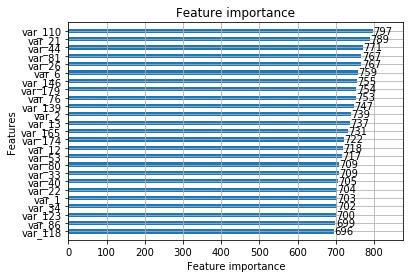

In [37]:
lgb.plot_importance(cv_model, max_num_features=25, height=0.5, importance_type='split')


In [38]:
y_predictions = cv_model.predict_proba(test_df[predictor_cols], 
                                       ntree_limit=cv_model.best_iteration_)[:, 1]

In [39]:
file_name = 'lgb_submission_use_unique.csv'
submission_df = test_df[['ID_code']]
submission_df['target'] = y_predictions
submission_df.to_csv(file_name, header=True, index=False, mode='w')


In [25]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='minority', n_jobs=multiprocessing.cpu_count())

In [40]:
@jit
def augment(x, y, t=2, shuff_features=200):
    xs, xn = [], []
    for i in range(t):
        mask = y > 0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:, c] = x1[ids][:, c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:, c] = x1[ids][:, c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x, xs, xn])
    y = np.concatenate([y, ys, yn])
    return x, y

In [41]:
predictor_cols = [c for c in train_df.columns if c not in ['ID_code', 'target']]
# predictor_cols = features = [c for c in train_part_1_df.columns if c not in ['ID_code', 'target', 'date']]

In [39]:
num_folds = 10
#folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2319)
folds = KFold(n_splits=num_folds, shuffle=False, random_state=2319)

In [64]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_features = sc.fit_transform(train_df[features])
test_features = sc.transform(test_df[features])
sc_train_df = pd.DataFrame(train_features, columns=features)
sc_test_df = pd.DataFrame(test_features, columns=features)

In [10]:
def cv_training(_data, _test_data, _predictor_cols, _target_col, _is_augment=False):
    y_predictions = np.zeros(_test_data.shape[0]) 
    oof = np.zeros(train_df.shape[0])

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(_data[_predictor_cols].values,
                                                           _data[_target_col].values)):
        print("===== Fold {} =====".format(fold_))
        
        train_X, train_y = _data.iloc[trn_idx][_predictor_cols], _data.iloc[trn_idx][_target_col] 
        valid_X, valid_y = _data.iloc[val_idx][_predictor_cols], _data.iloc[val_idx][_target_col]
        if _is_augment:
            over_train_x, over_trian_y = augment(train_X.values, train_y.values)
            over_train_x_df = pd.DataFrame(over_train_x)
            eval_set = [(over_train_x, over_trian_y), (valid_X, valid_y)]
            cv_model = lgb.LGBMClassifier(**sk_params)
            cv_model.fit(X=over_train_x,
                         y=over_trian_y, 
                         eval_set=eval_set,             
                         early_stopping_rounds=num_early_stopping, 
                         verbose=num_verbose_eval)
        else:
            eval_set = [(train_X, train_y), (valid_X, valid_y)]
            cv_model = lgb.LGBMClassifier(**sk_params)
            cv_model.fit(X=train_X,
                         y=train_y, 
                         eval_set=eval_set,             
                         early_stopping_rounds=num_early_stopping, 
                         verbose=num_verbose_eval)
                     #categorical_feature=list(convert_to_categories_cols)) 

        oof[val_idx] = cv_model.predict_proba(_data.iloc[val_idx][_predictor_cols], 
                                              ntree_limit=cv_model.best_iteration_)[:, 1]
        #oof_2 = cv_model.predict_proba(train_part_2_df[predictor_cols], 
        #                               ntree_limit=cv_model.best_iteration_)[:, 1]     
        #oof_2_df = pd.DataFrame(oof_2, columns=['oof_{}'.format(fold_)])
        #part_2_df = pd.concat([part_2_df, oof_2_df], axis=1)

        y_predictions += cv_model.predict_proba(_test_data[_predictor_cols], 
                                               ntree_limit=cv_model.best_iteration_)[:, 1] / folds.n_splits
        #y_pred_tmp_df = pd.DataFrame(y_predictions, columns=['oof_{}'.format(fold_)])
        #y_pred_df = pd.concat([y_pred_df, y_pred_tmp_df], axis=1)

    print("\n >> CV score: {:<8.10f}".format(roc_auc_score(_data[_target_col], oof)))       
    return y_predictions, roc_auc_score(_data[_target_col], oof)


In [43]:
def cv_stacking(_data_part_1, _data_part_2, _test_data, _predictor_cols, _target_col,
                _is_augment=False):
    y_predictions = np.zeros(_test_data.shape[0]) 
    oof_1 = np.zeros(train_part_1_df.shape[0])
    oof_2 = np.zeros(train_part_2_df.shape[0])
    train_level_2_df = pd.DataFrame()
    test_level_2_df = pd.DataFrame()
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(_data_part_1[_predictor_cols].values,
                                                           _data_part_1[_target_col].values)):
        print("===== Fold {} =====".format(fold_))
        
        train_X, train_y = _data_part_1.iloc[trn_idx][_predictor_cols], _data_part_1.iloc[trn_idx][_target_col] 
        valid_X, valid_y = _data_part_1.iloc[val_idx][_predictor_cols], _data_part_1.iloc[val_idx][_target_col]
        if _is_augment:
            over_train_x, over_trian_y = augment(train_X.values, train_y.values)
            over_train_x_df = pd.DataFrame(over_train_x)
            eval_set = [(over_train_x, over_trian_y), (valid_X, valid_y)]
            cv_model = lgb.LGBMClassifier(**sk_params)
            cv_model.fit(X=over_train_x,
                         y=over_trian_y, 
                         eval_set=eval_set,             
                         early_stopping_rounds=num_early_stopping, 
                         verbose=num_verbose_eval)
        else:
            eval_set = [(train_X, train_y), (valid_X, valid_y)]
            cv_model = lgb.LGBMClassifier(**sk_params)
            cv_model.fit(X=train_X,
                         y=train_y, 
                         eval_set=eval_set,             
                         early_stopping_rounds=num_early_stopping, 
                         verbose=num_verbose_eval)
                     #categorical_feature=list(convert_to_categories_cols)) 

        oof_1[val_idx] = cv_model.predict_proba(_data_part_1.iloc[val_idx][_predictor_cols], 
                                                ntree_limit=cv_model.best_iteration_)[:, 1]
        
        oof_2 = cv_model.predict_proba(_data_part_2[predictor_cols], 
                                        ntree_limit=cv_model.best_iteration_)[:, 1]     
        
        oof_2_df = pd.DataFrame(oof_2, columns=['oof_{}'.format(fold_)])
        train_level_2_df = pd.concat([train_level_2_df, oof_2_df], axis=1)

        y_predictions += cv_model.predict_proba(_test_data[_predictor_cols], 
                                               ntree_limit=cv_model.best_iteration_)[:, 1] / folds.n_splits
        y_pred_tmp_df = pd.DataFrame(y_predictions, columns=['oof_{}'.format(fold_)])
        test_level_2_df = pd.concat([test_level_2_df, y_pred_tmp_df], axis=1)

    print("\n >> CV score: {:<8.10f}".format(roc_auc_score(_data_part_1[_target_col], oof_1)))       
    return train_level_2_df, test_level_2_df, roc_auc_score(_data[_target_col], oof)


In [68]:
sc_train_df = pd.concat([sc_train_df, train_df[features]], axis=1)
sc_test_df = pd.concat([sc_test_df, test_df[features]], axis=1)

In [ ]:
y_pred, auc_score = cv_training(train_df, test_df, predictor_cols, target_col, 
                                _is_augment=True)


===== Fold 0 =====
Training until validation scores don't improve for 4000 rounds.
[5000]	valid_0's auc: 0.911777	valid_1's auc: 0.891115
[10000]	valid_0's auc: 0.921512	valid_1's auc: 0.895066
[15000]	valid_0's auc: 0.92876	valid_1's auc: 0.896091
[20000]	valid_0's auc: 0.935329	valid_1's auc: 0.896092
Early stopping, best iteration is:
[16704]	valid_0's auc: 0.931034	valid_1's auc: 0.896435
===== Fold 1 =====
Training until validation scores don't improve for 4000 rounds.
[5000]	valid_0's auc: 0.910914	valid_1's auc: 0.903078
[10000]	valid_0's auc: 0.920691	valid_1's auc: 0.908554
[15000]	valid_0's auc: 0.928017	valid_1's auc: 0.909565
Early stopping, best iteration is:
[14911]	valid_0's auc: 0.927895	valid_1's auc: 0.909584
===== Fold 2 =====
Training until validation scores don't improve for 4000 rounds.
[5000]	valid_0's auc: 0.911766	valid_1's auc: 0.890725
[10000]	valid_0's auc: 0.921614	valid_1's auc: 0.89397
[15000]	valid_0's auc: 0.928868	valid_1's auc: 0.894558
Early stopping

In [ ]:
train_level_2_df, test_level_2_df, auc_score = cv_stacking(train_part_1_df, 
                                                           train_part_2_df, test_df, 
                                                           predictor_cols, 
                                                           target_col, 
                                                           _is_augment=True)

In [13]:
file_name = 'lgb_submission_only_feature_slice_windows.csv'
submission_df = test_df[['ID_code']]
submission_df['target'] = y_pred
submission_df.to_csv(file_name, header=True, index=False, mode='w')


In [14]:
# check correlations with previously result
from scipy.stats.stats import pearsonr
nn_df = pd.read_csv('./nn_submission.csv')
cb_df = pd.read_csv('./cb_submission.csv')


In [18]:
pearsonr(nn_df[target_col].values, y_pred)

(0.9810304282258011, 0.0)

In [19]:
pearsonr(cb_df[target_col].values, y_pred)

(0.9222933162488419, 0.0)

# CatBoost

In [58]:
sk_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': num_of_iter,
    'learning_rate': 0.005,
    'random_state': seed,
    #'l2_leaf_reg': 0.01,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.4, # only use at bootstrap type is [Poisson, Bernoulli]
    'use_best_model': True,
    'depth': 5,
    'one_hot_max_size': 31,
    'colsample_bylevel': 0.4,
    'leaf_estimation_method': 'Gradient', # [Newton, Gradient]
    'class_weights': [1, 8.951238929246692],
    'max_bin': 128, # alias max_bin
    'use_best_model': True,
    'thread_count': multiprocessing.cpu_count()    
}

In [59]:
num_folds = 11
folds = StratifiedKFold(n_splits=num_folds, shuffle=False, random_state=2319)
oof_cb = np.zeros(train_df.shape[0])
y_predictions_cb = np.zeros(test_df.shape[0])

In [ ]:
for fold_, (train_idx, val_idx) in enumerate(folds.split(train_df[predictor_cols].values,
                                                         train_df[target_col].values)):
    print("===== Fold {} =====".format(fold_))
    
    train_X, train_y = train_df.iloc[train_idx][predictor_cols], train_df.iloc[train_idx][target_col] 
    valid_X, valid_y = train_df.iloc[val_idx][predictor_cols], train_df.iloc[val_idx][target_col]
    eval_set = [(train_X, train_y), (valid_X, valid_y)]
    cv_model = cb.CatBoostClassifier(**sk_params, od_type='Iter', od_wait=20)
    cv_model.fit(X=train_X,
                 y=train_y, 
                 eval_set=eval_set,             
                 early_stopping_rounds=num_early_stopping, 
                 verbose=num_verbose_eval) 
    
    oof_cb[val_idx] = cv_model.predict_proba(train_df.iloc[val_idx][predictor_cols], 
                                             ntree_end=cv_model.best_iteration_)[:, 1]
    y_predictions_cb +=  cv_model.predict_proba(test_df[predictor_cols], 
                                                ntree_end=cv_model.best_iteration_)[:, 1] / folds.n_splits
    
print("\n >> CV score: {:<8.10f}".format(roc_auc_score(train_df[target_col], oof_cb)))


===== Fold 0 =====
0:	test: 0.6196260	test1: 0.5973012	best: 0.5973012 (0)	total: 173ms	remaining: 2d 9m 21s
5000:	test: 0.9152808	test1: 0.8918786	best: 0.8918791 (4999)	total: 15m 30s	remaining: 2d 3h 24m 58s
10000:	test: 0.9345802	test1: 0.8969014	best: 0.8969031 (9995)	total: 30m 53s	remaining: 2d 2h 58m 2s
15000:	test: 0.9492535	test1: 0.8979270	best: 0.8979644 (14684)	total: 46m 15s	remaining: 2d 2h 37m 10s
Stopped by overfitting detector  (4000 iterations wait)

bestTest = 0.897966414
bestIteration = 15066

Shrink model to first 15067 iterations.
===== Fold 1 =====
0:	test: 0.6190083	test1: 0.6197627	best: 0.6197627 (0)	total: 166ms	remaining: 1d 22h 10m 53s
5000:	test: 0.9154997	test1: 0.8907716	best: 0.8907862 (4996)	total: 15m 32s	remaining: 2d 3h 31m 47s
10000:	test: 0.9347703	test1: 0.8952405	best: 0.8952426 (9997)	total: 31m 3s	remaining: 2d 3h 14m 27s
15000:	test: 0.9494584	test1: 0.8957647	best: 0.8957738 (14975)	total: 46m 31s	remaining: 2d 2h 54m 32s
20000:	test: 0.961

In [ ]:
file_name = 'cb_submission.csv'
submission_df = test_df[['ID_code']]
submission_df['target'] = ensemble
submission_df.to_csv(file_name, header=True, index=False, mode='w')


# Ensemble

In [89]:
ensemble = 0.75 * oof + 0.25 * oof_cb
print('NN+LightBGM auc = {:<8.10f}'.format(roc_auc_score(train_df[target_col], ensemble)))

NN+LightBGM auc = 0.9001412910


# Submission
Base Line submission : 0.500

In [90]:
submission_df = test_df[['ID_code']]
submission_df['target'] = ensemble

In [92]:
submission_df.to_csv('ensemble_submission.csv', header=True, index=False, mode='w')